# Introduction to Computer Vision - Lab 12

## Lab task

Use your already build convolutional neural network to perform single object detection and localization of C classes plus the ”no-object” class, with one of the schemes described in the Lecture Notes/Video 12.

To this end, you need to find yourself an appropriate data set from the net, that contains at least two classes plus the ”no-object” class (which you can create separately if not there).


In [1]:
import numpy as np
from tqdm import tqdm

np.random.seed(0)

## Load the dataset

Link to the dataset: [link](https://www.kaggle.com/datasets/danielpancake/image-localization-dataset/data) 

(P.S.: thanks to my colleague)

In [2]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

# Define the directory path with data
directory = 'training_images/'

# Initialize lists to store images and parsed XML data
images = []
labels = []
bound_boxes = []
labels_names = ['background', 'cucumber', 'eggplant']

# Get the dataset ready
for filename in tqdm(sorted(os.listdir(directory), 
                       key=lambda f: int(f.split('_')[1].split('.')[0])), 
                     desc='Preparing dataset...'):
    

    if filename.endswith('.jpg'):
        # Read the images and labels
        images.append(np.array(Image
                       .open(directory + filename)
                       .convert('RGB')))
        
        label = filename.split('.')[0].split('_')[0]
        labels = np.append(labels, labels_names.index(label)).astype(int)
      
    else:
        # Parse the XML file to get the data about the bounding boxes
        tree = ET.parse(directory + filename)
        root = tree.getroot()
        
        # Extract the bounding box coordinates and normalize them
        xmin = int(root.find('object/bbox/xmin').text) / 227
        ymin = int(root.find('object/bbox/ymin').text) / 227
        xmax = int(root.find('object/bbox/xmax').text) / 227
        ymax = int(root.find('object/bbox/ymax').text) / 227
        
        loc_chw = np.zeros((4, ))
        loc_chw[0] = (xmin + xmax) / 2
        loc_chw[1] = (ymin + ymax) / 2
        loc_chw[2] = (ymax - ymin)  # height
        loc_chw[3] = (xmax - xmin)  # width
        bound_boxes.append(loc_chw)

Preparing dataset...:   0%|          | 0/340 [00:00<?, ?it/s]

Preparing dataset...: 100%|██████████| 340/340 [00:00<00:00, 3810.59it/s]


In [3]:
# Split the dataset into train and test sets
def split_dataset(images, labels, bound_boxes, train_ratio):
    # Shuffle the dataset
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = np.array(images)[indices]
    labels = np.array(labels)[indices]
    bound_boxes = np.array(bound_boxes)[indices]

    train_images = images[:int(len(images) * train_ratio)]
    train_labels = labels[:int(len(images) * train_ratio)]
    train_bound_boxes = bound_boxes[:int(len(images) * train_ratio)]

    test_images = images[int(len(images) * train_ratio):]
    test_labels = labels[int(len(images) * train_ratio):]
    test_bound_boxes = bound_boxes[int(len(images) * train_ratio):]

    return train_images, train_labels, train_bound_boxes, test_images, test_labels, test_bound_boxes


train_images, train_labels, train_bound_boxes, test_images, test_labels, test_bound_boxes = split_dataset(images, labels, bound_boxes, 0.95)

In [4]:
print(len(train_images), len(test_images))

161 9


In [5]:
# Vectorize the train labels
train_labels_reshaped = train_labels.reshape(-1, 1)
num_labels = len(np.unique(train_labels))
train_labels_encoded = np.eye(num_labels)[train_labels_reshaped].squeeze()
print(train_labels[0])
print(train_labels_encoded[0])


0
[1. 0. 0.]


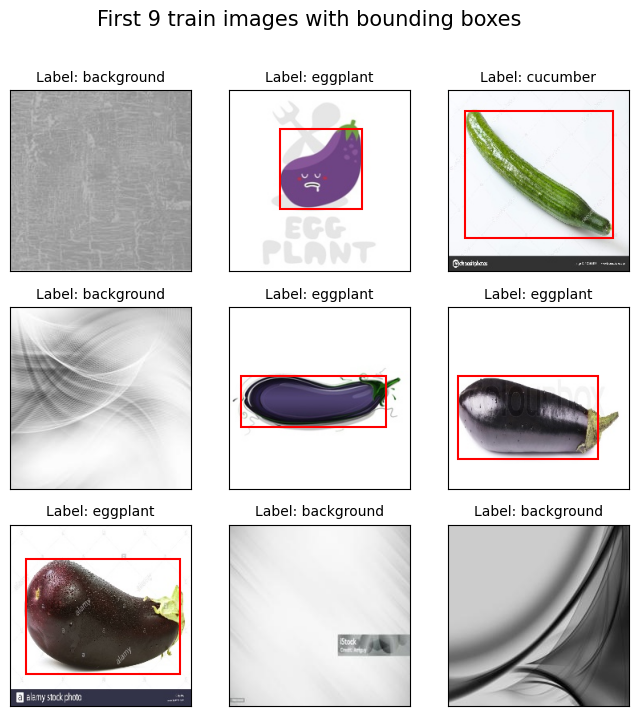

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot the first 9 train images with the corresponding labels and bounding boxes
imgs = [train_images[i] for i in range(9)]
boxes = [train_bound_boxes[i] for i in range(9)]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i])
    ax.set_title('Label: {}'.format(labels_names[train_labels[i]]), fontsize=10)
    rect = patches.Rectangle(xy=((boxes[i][0]-boxes[i][3]/2) * 227, 
                            (boxes[i][1] - boxes[i][2]/2) * 227), 
                            width=boxes[i][3] * 227, 
                            height=boxes[i][2] * 227, 
                            linewidth=1.5, 
                            edgecolor='r',
                            fill=False)
    ax.add_patch(rect)
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.suptitle('First 9 train images with bounding boxes', fontsize=15)
plt.show()

## Single object detection and classes localization

Here I will use already build CNN from the previous labs, but modify it to perform single object detection and classes localization. 

### Convolutional Layer

In [7]:
# Class representing the Convolutional Node with padding 
class ConvNode:

    def __init__(self, padding):
        self.Zk_prev = None # the previous feature map
        self.Wk = None # the filter
        self.padding = padding # padding size

    def forward(self, Zk_prev, Wk):
        # Forward propagation
        self.Zk_prev = Zk_prev
        self.Wk = Wk

        # Apply convolution operation
        depth, h, w = self.Zk_prev.shape
        _, hw, ww = self.Wk.shape
        
        # Apply padding to the input feature map
        if self.padding > 0:
            self.Zk_prev = np.pad(self.Zk_prev, ((0, 0), 
                                                (self.padding, self.padding), 
                                                (self.padding, self.padding)), 
                                mode='constant')
        
        Zk_h = h + 2 * self.padding - hw + 1
        Zk_w = w + 2 * self.padding - ww + 1

        Zk = np.zeros((Zk_h, Zk_w))

        for d in range(depth):
            Zk += self.convolve(self.Zk_prev[d, :, :], self.Wk[d, :, :])

        return Zk

    def backward(self, dL_dZk):
        # Bacward propagation
        dL_dWk = np.zeros_like(self.Wk)
        dL_dZk_prev = np.zeros_like(self.Zk_prev)

        # Compute gradients using formulas (5) and (9) from lecture slides
        for d_i in range(self.Wk.shape[0]):
            dL_dWk[d_i, :, :] = self.convolve(self.Zk_prev[d_i, :, :], dL_dZk)
            dL_dZk_prev[d_i, :, :] = self.convolve(self.pad(dL_dZk, self.Wk),
                                                   self.rotate(self.Wk[d_i, :, :]))
        
        # Remove padding from gradients
        if self.padding > 0:
            dL_dZk_prev = dL_dZk_prev[:, self.padding:-self.padding, self.padding:-self.padding]
            dL_dWk = dL_dWk[:, self.padding:-self.padding, self.padding:-self.padding]
            
        return dL_dWk, dL_dZk_prev

    def convolve(self, X, W):
        # Convolution operation between X and W that produces the matrix Z
        h, w = X.shape
        hw, ww = W.shape

        Z_h = h - hw + 1
        Z_w = w - ww + 1
        Z = np.zeros((Z_h, Z_w))

        for i in range(Z_h):
            for j in range(Z_w):
                Z[i, j] = np.sum(X[i:i+hw, j:j+ww] * W)

        return Z

    def rotate(self, Z):
        # Rotate the matrix Z by 180 degrees
        return np.flip(np.flip(Z, 1), 0)

    def pad(self, Z, Wk):
        # Pad the matrix Z with zeros
        return np.pad(Z, ((Wk.shape[1]-1, Wk.shape[1]-1),
                          (Wk.shape[2]-1, Wk.shape[2]-1)),
                        mode='constant')

In [8]:
# Class representing the Convolutional Layer
class ConvLayer:

    def __init__(self, D, filter_shape, Bk, padding=0):
        # D - number of filters
        self.D = D
        self.padding = padding
        
        # initialize the D filters
        self.filters = np.array([np.random.randn(*filter_shape) / 9 for _ in range(D)])
        self.conv_nodes = [ConvNode(padding) for _ in range(D)]
        self.Bk = Bk
        self.Zk = np.zeros_like(Bk)

    def forward(self, Zk_prev):
        # forward propagation
        self.Zk_prev = Zk_prev
        self.Zk = np.zeros_like(self.Bk)

        # apply convolution operation for each filter and after add bias
        for d in range(self.D):
            Zk_tilde = self.conv_nodes[d].forward(self.Zk_prev, self.filters[d])
            self.Zk[d, :, :] = Zk_tilde + self.Bk[d, :, :]

        return self.Zk

    def backward(self, dL_dZk):
        # backward propagation
        dL_dBk = dL_dZk
        
        dL_dWks = np.zeros_like(self.filters)
        dL_dZk_prev = np.zeros_like(self.Zk_prev)

        # compute gradients using formulas from lecture slides
        for d in range(self.D):
            dL_dWk, dL_dZk_prev_d = self.conv_nodes[d].backward(dL_dZk[d, :, :])
            dL_dWks[d] = dL_dWk
            dL_dZk_prev += dL_dZk_prev_d

        return dL_dBk, dL_dWks, dL_dZk_prev

### Activation functions

In [9]:
# Class representing the ReLU node (from the previous labs)
class ReLU:

    def __init__(self):
        self.x = None  # input values

    def forward(self, x):
        # calculate output of relu function
        self.x = x
        return np.maximum(0, self.x)

    def backward(self, loss_grad):
        # compute gradients with respect to the input values
        relu_der = np.where(self.x < 0, 0, 1) # local gradient of relu
        grad = relu_der * loss_grad
        return grad

In [10]:
# Class representing the Sigmoid node
class Sigmoid:
    
    def __init__(self):
        self.z = None
    
    def forward(self, x):
        # calculate output of sigmoid function
        self.z = 1 / (1 + np.exp(-x))
        return self.z
    
    def backward(self, loss_grad):
        # compute gradients with respect to the input 
        sigmoid_grad = loss_grad * self.z * (1 - self.z)
        return sigmoid_grad

In [11]:
# Class representing the Softmax node (from the previous labs)
class SoftmaxNode:

    def __init__(self):
        self.y_hat = None  # output of forward propagation
        self.grad = None  # gradient with respect to the input x (result of backward propagation)

    def forward(self, x):
        # calculate output of the softmax function with normalization
        self.x = x 
        self.x_norm = self.x / np.max(np.abs(self.x))
        e_x = np.exp(self.x_norm)
        self.y_hat = e_x / np.sum(e_x)
        return self.y_hat

    def backward(self, loss_grad):
        # compute gradients
        self.y_hat = self.y_hat.reshape(-1)

        softmax_grad = loss_grad * self.y_hat * (1 - self.y_hat)  # derivative of softmax

        softmax_grad = softmax_grad.reshape(-1)
        self.x = self.x.reshape(-1)

        grad = np.dot(self.x, softmax_grad) / (-np.max(np.abs(self.x))**2)

        self.grad = np.zeros_like(self.x, dtype=float)
        self.grad[np.argmax(self.x)] = grad
        self.grad *= np.sign(self.x)
        self.grad += softmax_grad * (1 / np.max(np.abs(self.x)))

        return self.grad.reshape(-1, 1)

### Vectorization Layer

In [12]:
# Class representing the Vectorization Layer
class VectorizationLayer:
    def __init__(self):
        self.input_shape = None

    def forward(self, X):
        # forward propagation
        self.input_shape = X.shape
        return X.reshape(-1, 1)

    def backward(self, dL_dZ):
        # backward propagation
        return dL_dZ.reshape(self.input_shape)

### Fully-Connected Layer

In [13]:
# Matrix multiplication node (from the previous labs)
class MulNode:

    def __init__(self):
        self.w = None  # input matrix W
        self.x = None  # input values x
        self.grad = None  # gradient with respect to W (result of backward propagation)

    def forward(self, w, x):
        # calculate output of multiplication W*X
        self.w, self.x = w, x
        return np.matmul(self.w, self.x)

    def backward(self, dL_dz):
        # compute gradient with respect to W
        dz_dw = self.x.reshape((1, self.x.shape[0]))
        self.grad = np.matmul(dL_dz, dz_dw)
        return self.grad

In [14]:
# Class representing the Fully Connected Layer
class FullyConnectedLayer:

    def __init__(self):
        self.mult = MulNode()

    def forward(self, X, W, b):
        # forward propagation
        self.W = W
        Z = self.mult.forward(self.W, X)
        return Z + b

    def backward(self, dL_dZ):
        # backward propagation
        dL_db = dL_dZ
        dL_dW = self.mult.backward(dL_dZ)
        dL_dX = np.dot(np.transpose(self.W), dL_dZ)
        return dL_db, dL_dW, dL_dX

### Define architectures of models

- Model 1: Convolutional Neural Network on detecting the class of the object;

- Model 2: Convolutional Neural Network on estimating the bounding box used for objects localization.



In [15]:
# Class representing the Convolutional Neural Network on detecting the class of the object (model 1)
class CNN1:
    def __init__(self):
        self.b1 = np.zeros((1, 223, 223))
        self.b2 = np.zeros((1, 215, 215))
        self.b3 = np.zeros((3, 1))  # since 3 classes
        self.W3 = np.random.randn(3, 215*215) / 10
        self.conv_layer1 = ConvLayer(D=1, filter_shape=(3, 5, 5), Bk=self.b1)
        self.relu1 = ReLU()
        self.conv_layer2 = ConvLayer(D=1, filter_shape=(1, 9, 9), Bk=self.b2)
        self.relu2 = ReLU()
        self.vectorize = VectorizationLayer()
        self.fc = FullyConnectedLayer()
        self.softmax = SoftmaxNode()

    def forward(self, X):
        # forward propagation
        Z = self.conv_layer1.forward(X)
        Z = self.relu1.forward(Z)
        Z = self.conv_layer2.forward(Z) 
        Z = self.relu2.forward(Z)
        Z = self.vectorize.forward(Z)
        Z = self.fc.forward(Z, self.W3, self.b3)
        Z = self.softmax.forward(Z)
        return Z

    def backward(self, dL_dZ):
        # backward propagation
        dL_dz = self.softmax.backward(dL_dZ)
        dL_db3, dL_dW3, dL_dz = self.fc.backward(dL_dz)
        dL_dz = self.vectorize.backward(dL_dz)
        dL_dz = self.relu2.backward(dL_dz)
        dL_dB2, dL_dW2, dL_dz = self.conv_layer2.backward(dL_dz)
        dL_dB1, dL_dW1, dL_dZ = self.conv_layer1.backward(dL_dz)
        return dL_dB1, dL_dW1[0], dL_dB2, dL_dW2[0], dL_db3, dL_dW3 

In [16]:
# Reshape the train images
train_images = train_images.reshape(-1, 3, 227, 227) 
train_images[0].shape

(3, 227, 227)

In [17]:
# check the model 1 forward propagation for the first image in the train set
model1 = CNN1()
model1.forward(train_images[0])

array([[0.56734535],
       [0.10755667],
       [0.32509798]])

In [18]:
# check the shapes of output of the model 1 backward propagation
dL_dB1, dL_dW11, dL_dB2, dL_dW2, dL_db3, dL_dW3 = model1.backward(1)
dL_dB1.shape, dL_dW11.shape, dL_dB2.shape, dL_dW2.shape, dL_db3.shape, dL_dW3.shape

((1, 223, 223), (3, 5, 5), (1, 215, 215), (1, 9, 9), (3, 1), (3, 46225))

In [19]:
# Class representing the Convolutional Neural Network on estimating the bounding box (model 2)
class CNN2:
    
    def __init__(self):
        self.b1 = np.zeros((1, 223, 223))
        self.b2 = np.zeros((1, 219, 219))
        self.b3 = np.zeros((4, 1))
        self.W3 = np.random.uniform(-1, 1, (4, 219*219))
        self.conv_layer1 = ConvLayer(D=1, filter_shape=(3, 5, 5), Bk=self.b1)
        self.relu1 = ReLU()
        self.conv_layer2 = ConvLayer(D=1, filter_shape=(1, 5, 5), Bk=self.b2)
        self.relu2 = ReLU()
        self.vectorize = VectorizationLayer()
        self.fc1 = FullyConnectedLayer()
        self.sigmoid = Sigmoid()

    def forward(self, X):
        # forward propagation
        Z = self.conv_layer1.forward(X)
        Z = self.relu1.forward(Z)
        Z = self.conv_layer2.forward(Z)
        Z = self.relu2.forward(Z)
        Z = self.vectorize.forward(Z)
        Z = self.fc1.forward(Z, self.W3, self.b3)
        Z = self.sigmoid.forward(Z)
        return Z

    def backward(self, dL_dZ):
        # backward propagation
        dL_dz = self.sigmoid.backward(dL_dZ)
        dL_db3, dL_dW3, dL_dz = self.fc1.backward(dL_dz)
        dL_dz = self.vectorize.backward(dL_dz)
        dL_dz = self.relu2.backward(dL_dz)
        dL_dB2, dL_dW2, dL_dz = self.conv_layer2.backward(dL_dz)
        dL_dz = self.relu1.backward(dL_dz)
        dL_dB1, dL_dW1, dL_dZ = self.conv_layer1.backward(dL_dz)
        return dL_dB1, dL_dW1[0], dL_dB2, dL_dW2[0], dL_db3, dL_dW3

In [20]:
# check the model 2 forward propagation for the first image in the train set
model2 = CNN2()
model2.forward(train_images[0])

array([[0.5],
       [0.5],
       [0.5],
       [0.5]])

In [21]:
# check the shapes of output of the model 2 backward propagation
loss = np.array([1, 0, 0, 0]).reshape(-1, 1)
dL_dB1, dL_dW11, dL_dB2, dL_dW2, dL_db3, dL_dW3 = model2.backward(loss)
dL_dB1.shape, dL_dW11.shape, dL_dB2.shape, dL_dW2.shape, dL_db3.shape, dL_dW3.shape

((1, 223, 223), (3, 5, 5), (1, 219, 219), (1, 5, 5), (4, 1), (4, 47961))

### Perform the Mini-Batch Gradient Descent

Training models in parallel.

In [22]:
# define the batch size
batch_size = 10

# define the number of epochs
num_epochs = 10

# define the learning rates
eta = 0.01

# define the number of batches
num_batches = len(train_images) // batch_size

# perform the Mini-Batch Gradient Descent

# loop over the epochs
for epoch in tqdm(range(num_epochs)):

    # initialize the gradients for model 1
    dL_db11 = np.zeros_like(model1.b1)
    dL_db21 = np.zeros_like(model1.b2)
    dL_db31 = np.zeros_like(model1.b3)
    dL_dW11 = np.zeros_like(model1.conv_layer1.filters[0])
    dL_dW21 = np.zeros_like(model1.conv_layer2.filters[0])
    dL_dW31 = np.zeros_like(model1.W3)
    
    # initialize the gradients for model 2
    dL_db12 = np.zeros_like(model2.b1)
    dL_db22 = np.zeros_like(model2.b2)
    dL_db32 = np.zeros_like(model2.b3)
    dL_dW12 = np.zeros_like(model2.conv_layer1.filters[0])
    dL_dW22 = np.zeros_like(model2.conv_layer2.filters[0])
    dL_dW32 = np.zeros_like(model2.W3)
   

    # loop over the batches
    for batch in range(1, num_batches + 1):
        # get the batch data
        batch_x = train_images[(batch-1)*batch_size:batch*batch_size]
        batch_y = train_labels_encoded[(batch-1)*batch_size:batch*batch_size]
        batch_box_y = train_bound_boxes[(batch-1)*batch_size:batch*batch_size]
        
        # loop over the batch data 
        for x, y, box_y in zip(batch_x, batch_y, batch_box_y):

            # perform forward propagation for model 1
            y_hat = model1.forward(x).reshape(-1)
            
            # perform forward propagation for model 2
            b_hat = model2.forward(x).reshape(-1)
            
            # compute the losses 1 and 2
            l1 = -np.sum(y * np.log(y_hat))
            l2 = (box_y[0] - b_hat[0])**2 + (box_y[1] - b_hat[1])**2 + (box_y[2] - b_hat[2])**2 + (box_y[3] - b_hat[3])**2

            # compute the gradient of the losses 1 and 2
            grad_l1 = -y / y_hat
            grad_l2 = np.array([2 * (b_hat[0] - box_y[0]),
                               2 * (b_hat[1] - box_y[1]),
                               2 * (b_hat[2] - box_y[2]),
                               2 * (b_hat[3] - box_y[3])]).reshape(-1, 1)

            # compute the gradients for model 1
            dL_db11_i, dL_dW11_i, dL_db21_i, dL_dW21_i, dL_db31_i, dL_dW31_i = model1.backward(grad_l1)
            dL_db11 += dL_db11_i
            dL_db21 += dL_db21_i
            dL_db31 += dL_db31_i
            dL_dW11 += dL_dW11_i
            dL_dW21 += dL_dW21_i
            dL_dW31 += dL_dW31_i
            
            # compute the gradients for model 2
            dL_db12_i, dL_dW12_i, dL_db22_i, dL_dW22_i, dL_db32_i, dL_dW32_i = model2.backward(grad_l2)
            dL_db12 += dL_db12_i
            dL_db22 += dL_db22_i
            dL_db32 += dL_db32_i
            dL_dW12 += dL_dW12_i
            dL_dW22 += dL_dW22_i
            dL_dW32 += dL_dW32_i


       # update the weights and biases for model 1
        model1.b1 -= eta * dL_db11 / batch_size
        model1.conv_layer1.filters[0] -= eta * dL_dW11 / batch_size
        model1.b2 -= eta * dL_db21 / batch_size
        model1.conv_layer2.filters[0] -= eta * dL_dW21 / batch_size
        model1.b3 -= eta * dL_db31 / batch_size
        model1.W3 -= eta * dL_dW31 / batch_size
        
        # update the weights and biases for model 2
        model2.b1 -= eta * dL_db12 / batch_size
        model2.conv_layer1.filters[0] -= eta * dL_dW12 / batch_size
        model2.b2 -= eta * dL_db22 / batch_size
        model2.conv_layer2.filters[0] -= eta * dL_dW22 / batch_size
        model2.b3 -= eta * dL_db32 / batch_size
        model2.W3 -= eta * dL_dW32 / batch_size


100%|██████████| 10/10 [54:15<00:00, 325.51s/it]


## Results

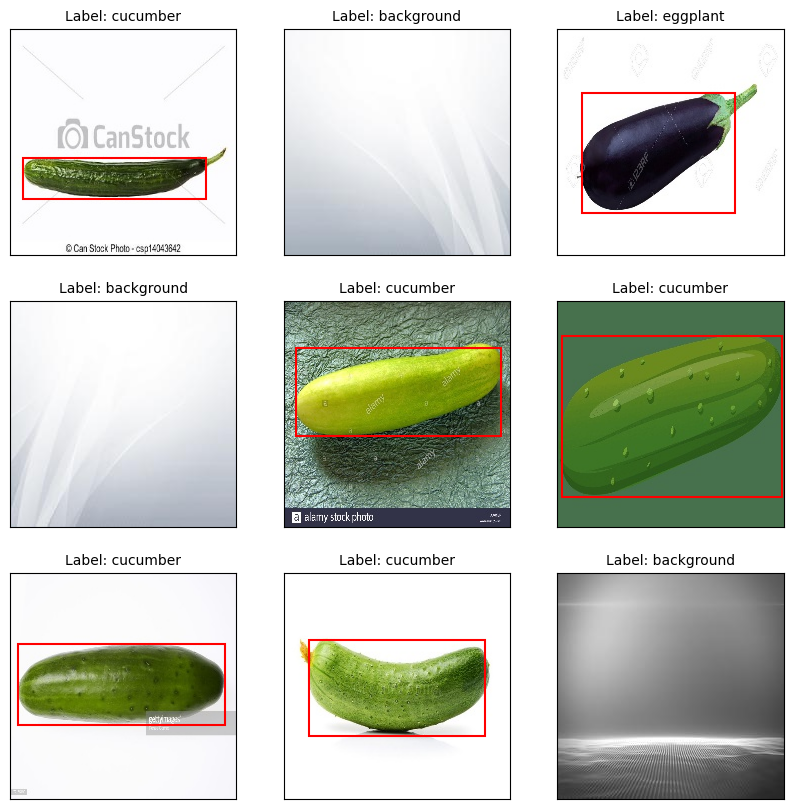

In [25]:
# Plot results on test images with true and predicted bounding boxes
N = len(test_images)
imgs = [test_images[i] for i in range(N)]
boxes = [test_bound_boxes[i] for i in range(N)]
test_images = test_images.reshape(-1, 3, 227, 227)
pred_boxes = [model2.forward(test_images[i]).reshape(-1) for i in range(N)]
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    ax.imshow(imgs[i])
    # Plot the true and predicted bounding boxes
    ax.set_title('Label: {}'.format(labels_names[test_labels[i]]), fontsize=10)
    true_rect = patches.Rectangle(xy=((boxes[i][0]-boxes[i][3]/2) * 227, 
                            (boxes[i][1] - boxes[i][2]/2) * 227), 
                            width=boxes[i][3] * 227, 
                            height=boxes[i][2] * 227, 
                            linewidth=1.5, 
                            edgecolor='r',
                            fill=False)
    ax.add_patch(true_rect)

    pred_rect = patches.Rectangle(xy=((pred_boxes[i][0]-pred_boxes[i][3]/2) * 227, 
                                (pred_boxes[i][1] - pred_boxes[i][2]/2) * 227), 
                                width=pred_boxes[i][3] * 227, 
                                height=pred_boxes[i][2] * 227, 
                                linewidth=1.5, 
                                edgecolor='g',
                                fill=False)
    ax.add_patch(pred_rect)
        
    ax.set_xticks([])
    ax.set_yticks([])